# Model inference II

Based on the variational posterior of the parameter $\beta$ and $\rho$, we aim to have following inference from the model. 

+ Species similarity based on the species specific latent vector $\beta$ (cosine distance used)
+ Identify positive  interaction among species using positive entries in in the interaction matrix $\rho^{T}\beta$
+ Identify negative  interaction among species using negative entries in in the interaction matrix $\rho^{T}\beta$


In [1]:
## call python script to load data and column order
import os
exec(open('data_file.py').read())
# load packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pltx
import seaborn as sns
import pystan
import pickle
import scipy.cluster.hierarchy as sch
import copy
import vb_stan as vbfun
import sub_fun as sf
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker
import copy 
import random
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import kneighbors_graph
from fa2 import ForceAtlas2
from networkx.algorithms.community import greedy_modularity_communities
import networkx as nx
random.seed(123)
figfol = 'mem_plot/'

plt.rcParams.update(plt.rcParamsDefault)
params = {'legend.fontsize': 12,
          'font.weight': 'bold',
         'axes.labelsize': 12,
         'axes.titlesize':12,
         'axes.labelweight': 'bold',
         'xtick.labelsize':12,
          'axes.titleweight': 'bold',
         #'figure.figsize': (15,8),
          'figure.dpi': 200,
         'ytick.labelsize':12}
plt.rcParams.update(params)

%matplotlib inline
distinct_colp = ["maroon","brown","olive", "teal", "lightgreen", "red", "orange",\
 "yellow", "lime", "green", "cyan", "blue", "purple", "magenta",\
 "grey", "pink", "darkorange", "beige", "slategray", "lavender", "navy",\
     "cornflowerblue","olivedrab",'greenyellow','peru','darkslateblue']
# https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib
# from fa2 import ForceAtlas2

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


In [2]:
# Call the output from the fitted model:
fname_best = '66_model_nb_cvtest.pkl'
folname = 'MMSens/'
[holdout_mask, llpd, n_test, l,m_seed,sp_mean,\
 sp_var, h_prop, uid, nsample_o, Yte_fit, cv_test] = pickle.load(open(folname + fname_best, "rb"))

# -------------------------------------------------
# save model output 
fname_ot = folname + str(uid) + '_' + 'model_nb.pkl' 
#with open(fname_o, 'wb') as f:
#    pickle.dump(NB_vb, f)
with open(fname_ot, 'rb') as f:
    results = pickle.load(f)
    
sample_fname = folname + str(uid) + '_' + 'sample_model_nb_cvtest.pkl' 
with open(sample_fname, 'rb') as f:
    [Yte_sample,Yte_cv] = pickle.load(f)

parma_mean  = dict(vbfun.vb_extract_mean(results))

/mnt/home/amishra/jobs/microbiome/embeddings/vb_stan.py:57: RuntimeWarning: invalid value encountered in multiply
  params = OrderedDict([(name, np.nan * np.empty(shape)) for name, shape in param_shapes.items()])


In [3]:
## Extract annotation of the microbial species 
tax_name = pd.read_csv('species_tax.csv')
tax_name = tax_name.rename(columns={'Unnamed: 0': 'OTU'})
tax_name = tax_name[1:]
tax_name.insert(0, 'Id', tax_name['OTU'].str[3:])
tax_name.columns.values[1] = 'Label'
tax_name.to_csv('node_otu.csv', index = False) 
temx = tax_name.iloc[:,:8]
temx = temx.replace(np.nan,'')
species_name = []
# Add taxonomy identifier to the each of the species name 
for i in range(temx.shape[0]):
    a = temx.iloc[i,:].values
    for j in range(a.shape[0]-1,-1,-1):
        if len(a[j]) > 0:
            species_name.append(temx.columns[j][0].lower()+'_'+ a[j])
            break;           
species_name = np.array(species_name)  
tax_name['Name'] = species_name
# tax_name['ord_abu'] = np.linspace(10,1,tax_name.shape[0])[(-1*Y.mean(axis=0)).argsort()]
tax_name['Abundance'] = Y.sum(axis=0)
tax_name[['Id']] = tax_name[['Id']].values.astype(np.int64)
tax_name = tax_name.replace(np.nan,'Empty')
tem = pd.read_csv('species_tax_anot.amended.csv').iloc[:,[1,12]]
tax_name = tax_name.merge(tem,on = 'Label')
tax_name = tax_name.rename(columns={"Ecologically_relevant_classification_aggregated": "ECR"})

## Update the new annotation in the
i = 11    # index for ECR variable 
ind_var = tax_name.iloc[:,i].values
vals, counts = np.unique(ind_var, return_counts=True)
tem_ind1 = (-1*counts).argsort()
tem_val = vals[tem_ind1][range(np.min([np.sum(counts > 10),tem_ind1.shape[0]]))]
tmp = np.setdiff1d(np.unique(ind_var), tem_val)
import sub_fun as sf
tmp = sf.return_indices_of_a(tmp, ind_var)
ind_var[tmp] = "Other" 
tax_name.iloc[:,i] = ind_var


### <font color=blue>Positive  and Negative interactions based on $\rho^{T}\beta$ estimate</font>




In [4]:
selected_species = list(np.unique(tax_name['ECR']))
#selected_species.remove('Other')
selected_species_index = tax_name['ECR'].isin(selected_species).values
species_col_dict = dict(zip(selected_species,distinct_colp[:len(selected_species)]))

In [5]:
## Species- species interactiion matrix estimate 
cov_mat = np.matmul(parma_mean['L_sp'],parma_mean['L_i'].T)
cov_mat  = cov_mat  #cov_mat.max() - cov_mat
cov_mat = (cov_mat + cov_mat.T)/2
np.fill_diagonal(cov_mat,0)

selected_species_index = tax_name['ECR'].isin(selected_species).values
dist_pos = copy.copy(cov_mat[selected_species_index][:,selected_species_index])
dist_neg = copy.copy(cov_mat[selected_species_index][:,selected_species_index])
for i in range(dist_pos.shape[0]):
    tem = dist_pos[i].argsort()
    dist_pos[i,tem[:-5]] = 0. 
    dist_neg[i,tem[5:]] = 0.
    
dist_neg = dist_neg*(-1.0)
    

In [6]:
# Sanity check
sum(sum(dist_pos>0))/5
sum(sum(dist_neg>0))/5

1378.0

### <font color=blue>Use dist_neg and dist_pos to compute the number of positive and negative interaction matrix summary and negative interaction matrix abong ERC type of the OTUs</font>
+ Step1: compute inetreaction matrix 
+ Use heatmap to showcase the number of interactions 
+ One heatmap with upper and lower triangulas number of positive and negative interaction 

In [7]:
tax_name3 = copy.copy(tax_name)
tax_name3['Id'] =  tax_name3['Label']
tax_name3 = tax_name3[selected_species_index]
ECR = np.unique(tax_name3['ECR'])

temp_pos = np.zeros((len(ECR),len(ECR)))
for i in range(len(ECR)):
    for j in range(len(ECR)):
        r_ind = tax_name3['ECR'] == ECR[i]
        c_ind = tax_name3['ECR'] == ECR[j]
        temp_pos[i,j] = np.sum(dist_pos[r_ind,][:,c_ind]>0)
temp_pos  = temp_pos. astype(np.int)    
temp_pos =  temp_pos + temp_pos.T
np.fill_diagonal(temp_pos, np.diag(temp_pos)/2)
# temp_pos[np.triu_indices(len(ECR),1)] = 0
# np.sum(temp_pos)/5 # sanity check
temp_pos = pd.DataFrame(temp_pos)
temp_pos.index = [i.replace(' (', '\n(') for i in ECR] 
temp_pos.columns = [i.replace(' (', '\n(') for i in ECR] 




In [8]:
temp_neg = np.zeros((len(ECR),len(ECR)))
for i in range(len(ECR)):
    for j in range(len(ECR)):
        r_ind = tax_name3['ECR'] == ECR[i]
        c_ind = tax_name3['ECR'] == ECR[j]
        temp_neg[i,j] = np.sum(dist_neg[r_ind,][:,c_ind]>0)
temp_neg  = temp_neg. astype(np.int)    
temp_neg =  temp_neg + temp_neg.T
np.fill_diagonal(temp_neg, np.diag(temp_neg)/2)
#temp_neg[np.triu_indices(len(ECR))] = 0

temp_neg = pd.DataFrame(temp_neg)
temp_neg.index = [i.replace(' (', '\n(') for i in ECR] 
temp_neg.columns = [i.replace(' (', '\n(') for i in ECR] 



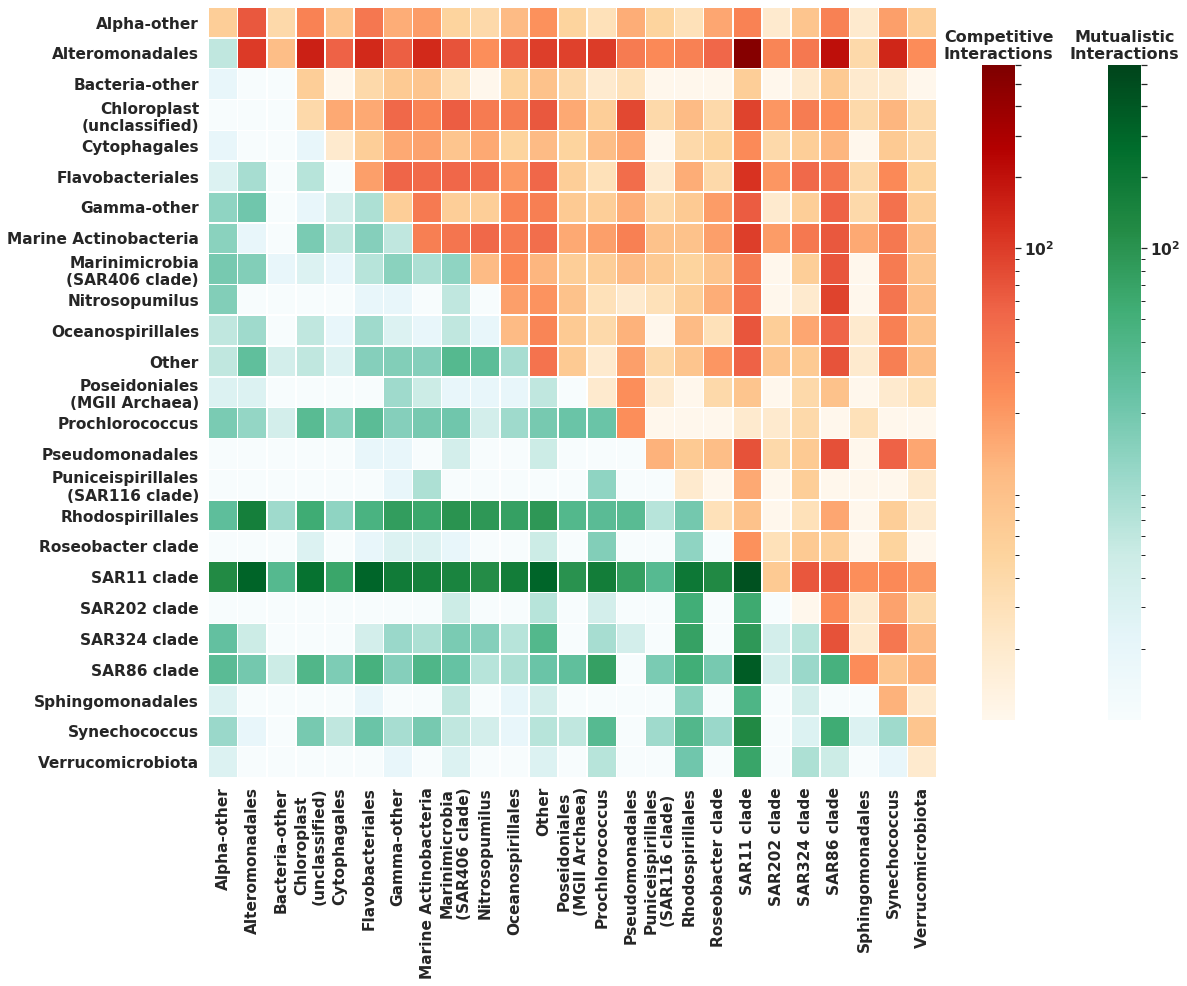

In [10]:
mask1 = np.zeros(temp_pos.shape)
mask1[np.triu_indices(len(ECR),0)] = True

mask2 = np.zeros(temp_pos.shape)
mask2[np.tril_indices(len(ECR),0)] = True
for i in range(temp_pos.shape[0]):
    if temp_pos.iloc[i,i] >= temp_neg.iloc[i,i]:
        mask1[i,i] = False
    else:
        mask2[i,i] = False

sns.set(font_scale=1.4)
from matplotlib.colors import LogNorm, Normalize

f, ax = plt.subplots(figsize=(18, 14))
sns.heatmap(temp_pos+1,annot=False,   mask=mask1,vmin=1, norm=LogNorm(),   vmax=600, square=False,\
                annot_kws={"fontsize": 18}, cbar = True, cbar_kws = {'orientation':'vertical',"shrink": .85, "pad":-.01},\
                fmt='', ax = ax, cmap = 'BuGn',linewidths=.5)
sns.heatmap(temp_neg+1,annot=False,   mask=mask2,vmin=1,norm=LogNorm(),    vmax=600, square=False,\
                annot_kws={"fontsize": 18}, cbar = True, cbar_kws = {'orientation':'vertical', "shrink": .85},\
                fmt='', ax = ax, cmap = 'OrRd',linewidths=.5)
cbar0 = ax.collections[0].colorbar
cbar1 = ax.collections[1].colorbar
cbar0.ax.set_title('Mutualistic\nInteractions',fontsize=16)
cbar1.ax.set_title('Competitive\nInteractions',fontsize=16)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.yaxis.label.set_size(20)
f.tight_layout()
f.savefig(figfol + 'temp.png')

In [24]:
pd.DataFrame([temp_pos.sum(axis = 1), temp_neg.sum(axis = 1)]).T


,0,1
Alpha-other,316,346
Alteromonadales,602,2275
Bacteria-other,55,67
Chloroplast\n(unclassified),416,795
Cytophagales,125,235
Flavobacteriales,525,805
Gamma-other,402,529
Marine Actinobacteria,398,855
Marinimicrobia\n(SAR406 clade),445,473
Nitrosopumilus,285,434


In [52]:
f, ax = plt.subplots(figsize=(18, 14))
sns.heatmap(np.log((temp_pos+1)/(temp_neg+1)),annot=False,    square=False, \
                annot_kws={"fontsize": 18}, cbar = True, cbar_kws = {'orientation':'vertical',"shrink": .85, "pad":.05},\
                fmt='', ax = ax, cmap = 'RdBu',linewidths=.5)
cbar0 = ax.collections[0].colorbar
cbar0.ax.set_title('Interactions',fontsize=16)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.yaxis.label.set_size(20)
f.tight_layout()
f.savefig(figfol + 'temp.png') norm=LogNorm(),


SyntaxError: invalid syntax (<ipython-input-52-035bfbcfd48a>, line 11)

In [35]:
np.max((temp_pos+1)/(temp_neg+1))

Alpha-other                            9.666667
Alteromonadales                        5.290323
Bacteria-other                        10.000000
Chloroplast\n(unclassified)            5.500000
Cytophagales                           3.250000
Flavobacteriales                      10.333333
Gamma-other                           11.428571
Marine Actinobacteria                  7.111111
Marinimicrobia\n(SAR406 clade)        20.200000
Nitrosopumilus                        15.166667
Oceanospirillales                      6.818182
Other                                 11.250000
Poseidoniales\n(MGII Archaea)         37.000000
Prochlorococcus                       87.000000
Pseudomonadales                        4.714286
Puniceispirillales\n(SAR116 clade)    18.000000
Rhodospirillales                      54.000000
Roseobacter clade                     16.000000
SAR11 clade                           87.000000
SAR202 clade                          54.000000
SAR324 clade                          24


#### <font color=blue>Top 5 positive interaction of each species</font>

In [10]:
# Take positive interaction matrix, prepare node attribute and get forceatlas2 layout for the networkx plot
dist = copy.copy(dist_pos)
tax_name3 = copy.copy(tax_name)
tax_name3['Id'] =  tax_name3['Label']
tax_name3 = tax_name3[selected_species_index]

## Select species based on #k = 10# neares neighbour and see graph 
node_id = tax_name3['Label'].values
species_selected = pd.DataFrame()
for i in range(dist.shape[0]):
    a = np.where(dist[i] != 0.)[0]
    if a.shape[0] > 0:
        d = {'Id': node_id[i],'Source': node_id[i], 'Target': node_id[a],\
         'Type' : 'Undirected', 'Weightx': 1.0,\
         'weight': 1.0 } # dist[i][a]
        species_selected = species_selected.append(pd.DataFrame(data=d))
# sanity check
#species_selected.to_csv('edge_cosinedist_posit.csv', index = False)
species_selected = pd.merge(species_selected, tax_name3, on='Id')



tax_name3['color'] = [species_col_dict[n] for n in tax_name3['ECR'].values]
node_atr = {}
for i in range(tax_name3.shape[0]):
    node_atr[tax_name3['Id'].values[i] ] = tax_name3.iloc[i,1:].to_dict()
    



np.random.seed(1234)
out = species_selected
g = nx.from_pandas_edgelist(out, source='Source', target='Target',\
                             edge_attr = 'weight',\
                             create_using=nx.Graph()) 
#layout = nx.circular_layout(g)
nx.set_node_attributes(g, node_atr)
deg = g.degree()
val, counts = np.unique([a for (n, a) in deg], return_counts=True)
to_keep = [n for (n, a) in deg if a > 0]
deg_keep = [n for n, a in deg if a > 150]
Gt_d = g.subgraph(deg_keep)
g_sub = g.subgraph(to_keep)

In [11]:
val, counts

(array([  5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
         18,  19,  20,  21,  22,  23,  24,  25,  26,  28,  29,  33,  37,
         41,  45,  46,  47,  49,  55,  57,  58,  59,  61,  65,  66,  69,
         70,  73,  82, 105, 110, 116, 119, 129, 132, 155, 158, 162, 166,
        172, 178, 207, 223, 249, 356, 363, 372, 400, 401, 402, 490]),
 array([1229,   33,   15,    7,    8,    3,    3,    3,    5,    1,    2,
           2,    3,    3,    4,    1,    2,    2,    1,    2,    1,    1,
           1,    1,    3,    1,    2,    1,    1,    1,    1,    1,    1,
           2,    1,    1,    1,    1,    1,    1,    1,    1,    2,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1]))

In [12]:
#layout = nx.spring_layout(g_sub,iterations=100, scale =2, k=3*1/np.sqrt(len(g_sub.nodes())))
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

random.seed(123)
positions1 = forceatlas2.forceatlas2_networkx_layout(g_sub, pos=None, iterations=2000)
# positions = nx.spring_layout(g_sub, pos=None, iterations=200, seed = 123, weight = None)
layout = positions1

100%|██████████| 2000/2000 [00:52<00:00, 38.43it/s]

BarnesHut Approximation  took  39.28  seconds
Repulsion forces  took  10.90  seconds
Gravitational forces  took  0.12  seconds
Attraction forces  took  0.20  seconds
AdjustSpeedAndApplyForces step  took  0.69  seconds


/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


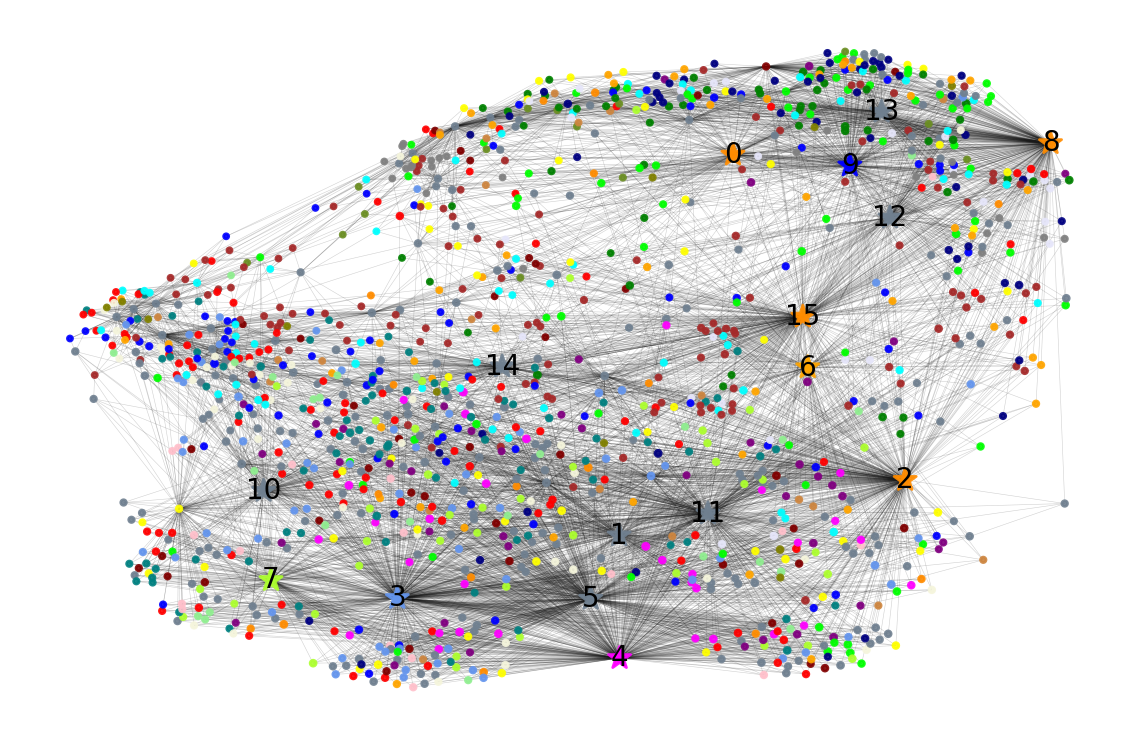

In [13]:
# Draw positive interaction network plot and highlight the most important nodes *star*
club_size = [g_sub.degree(club) for club in list(g_sub)]
n_size = [g_sub.nodes[club]['Abundance'] for club in list(g_sub)]
edges = g_sub.edges()
widths_n = weights = 2*np.array([g_sub[u][v]['weight'] for u,v in edges])
clubsx = [str(x) +'[' +str(y)+']' for x,y in zip(list(g_sub),club_size)]
node_labl = [g_sub.nodes[n]['ECR'] for n in list(g_sub) ]
 
colors2 = [g_sub.nodes[n]['color']  for n in list(g_sub) ]
Gt = Gt_d
colors3 = [Gt.nodes[n]['color']  for n in list(Gt) ]

#fnamex = 'species_interaction_mat1.pdf'
# pp = PdfPages(fnamex)
fig, ax  = plt.subplots(dpi = 200)
nx.draw_networkx_edges(g_sub, layout, width=0.1*widths_n, alpha=0.2, ax =ax)
nc = nx.draw_networkx_nodes(g_sub, 
                       layout, 
                       nodelist=list(g_sub), 
                       node_size= 0.5*np.log(n_size), # a LIST of sizes, based on g.degree
#                       node_color='blue',\
                       ax = ax,alpha = 0.9,
                       #label= node_labl,
                       node_color=colors2)

# draw the most important nodes with a different style
nx.draw_networkx_nodes(Gt,layout,node_shape="*",alpha=0.9,node_color=colors3, 
                       nodelist=list(Gt),
                       node_size = 70)
nx.draw_networkx_labels(Gt, layout, font_size=10, font_color='black',\
                        labels={list(Gt)[i]:i for i in range(len(list(Gt)))},\
                            horizontalalignment = 'center',verticalalignment = 'center')

#nx.draw_networkx_labels(Gt,layout,font_size=12,font_color='b')
#plt.colorbar(nc)
ax.axis('off')
# ax.set_title("Species species interaction", fontsize = 10)
fig.tight_layout()
#pp.savefig(fig,dpi = 200, bbox_inches='tight', pad_inches=0)
fig.savefig(figfol + 'MI2SPSPos.png')


In [14]:
## Interaction matrix 
A = nx.adjacency_matrix(g_sub, weight = None).toarray()
selind = np.isin(list(g_sub), list(Gt))
temp_df = pd.DataFrame(A[selind].transpose())
temp_df.columns = list(Gt)
temp_df['ECR'] = [g_sub.nodes[n]['ECR'] for n in list(g_sub)]
df_plot = temp_df.groupby('ECR').agg('sum')
# df_plot.columns = [g_sub.nodes[n]['ECR'] for n in list(Gt)]
df_plot.columns = [g_sub.nodes[n]['ECR'] +' [' + n +']' for n in list(Gt)]
df_plotP = copy.copy(df_plot)

In [15]:
species_col_dict_ = {}
for n in list(g_sub):
    species_col_dict_[g_sub.nodes[n]['ECR']] = g_sub.nodes[n]['color']

#### <font color=blue>Top 5 negative interaction of each species</font>


In [16]:
# Take negative interaction matrix, prepare node attribute and get forceatlas2 layout for the networkx plot
dist = copy.copy(dist_neg)

tax_name3 = copy.copy(tax_name)
tax_name3['Id'] =  tax_name3['Label']
tax_name3 = tax_name3[selected_species_index]

## Select species based on #k = 10# neares neighbour and see graph 
node_id = tax_name3['Label'].values
species_selected = pd.DataFrame()
for i in range(dist.shape[0]):
    a = np.where(dist[i] != 0.)[0]
    if a.shape[0] > 0:
        d = {'Id': node_id[i],'Source': node_id[i], 'Target': node_id[a],\
         'Type' : 'Undirected', 'Weightx': 1.0,\
         'weight': 1.0 } # dist[i][a]
        species_selected = species_selected.append(pd.DataFrame(data=d))

#species_selected.to_csv('edge_cosinedist_posit.csv', index = False)
species_selected = pd.merge(species_selected, tax_name3, on='Id')



tax_name3['color'] = [species_col_dict[n] for n in tax_name3['ECR'].values]
node_atr = {}
for i in range(tax_name3.shape[0]):
    node_atr[tax_name3['Id'].values[i] ] = tax_name3.iloc[i,1:].to_dict()
    



np.random.seed(1234)
out = species_selected
g = nx.from_pandas_edgelist(out, source='Source', target='Target',\
                             edge_attr = 'weight',\
                             create_using=nx.Graph()) 
#layout = nx.circular_layout(g)
nx.set_node_attributes(g, node_atr)
deg = g.degree()
val, counts = np.unique([a for (n, a) in deg], return_counts=True)
to_keep = [n for (n, a) in deg if a > 0]
deg_keep = [n for n, a in deg if a > 110]
Gt_d = g.subgraph(deg_keep)
g_sub = g.subgraph(to_keep)

In [17]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

random.seed(123)
positions1 = forceatlas2.forceatlas2_networkx_layout(g_sub, pos=None, iterations=2000)
# positions = nx.spring_layout(g_sub, pos=None, iterations=200, seed = 123, weight = None)
layout = positions1

100%|██████████| 2000/2000 [00:50<00:00, 39.83it/s]

BarnesHut Approximation  took  36.69  seconds
Repulsion forces  took  11.65  seconds
Gravitational forces  took  0.12  seconds
Attraction forces  took  0.20  seconds
AdjustSpeedAndApplyForces step  took  0.70  seconds


/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


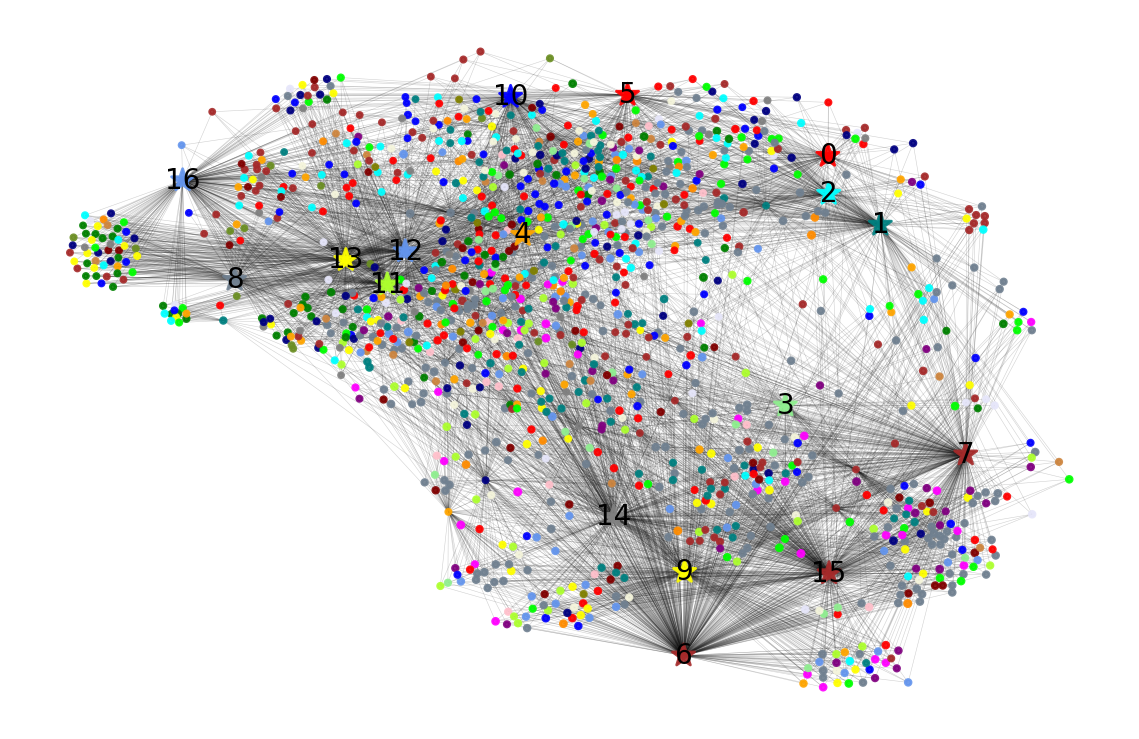

In [18]:
## Draw negative interaction network plot and highlight the most important nodes *star*
club_size = [g_sub.degree(club) for club in list(g_sub)]
n_size = [g_sub.nodes[club]['Abundance'] for club in list(g_sub)]
edges = g_sub.edges()
widths_n = weights = 2*np.array([g_sub[u][v]['weight'] for u,v in edges])
clubsx = [str(x) +'[' +str(y)+']' for x,y in zip(list(g_sub),club_size)]
node_labl = [g_sub.nodes[n]['ECR'] for n in list(g_sub) ]

colors2 = [g_sub.nodes[n]['color']  for n in list(g_sub) ]
Gt = Gt_d
colors3 = [Gt.nodes[n]['color']  for n in list(Gt) ]


#fnamex = 'species_interaction_mat1.pdf'
# pp = PdfPages(fnamex)
fig, ax  = plt.subplots(dpi = 200)
nx.draw_networkx_edges(g_sub, layout, width=0.1*widths_n, alpha=0.2, ax =ax)
nc = nx.draw_networkx_nodes(g_sub, 
                       layout, 
                       nodelist=list(g_sub), 
                       node_size= 0.5*np.log(n_size), # a LIST of sizes, based on g.degree
#                       node_color='blue',\
                       ax = ax,alpha = 0.9,
                       #label= node_labl,
                       node_color=colors2)

# draw the most important nodes with a different style
nx.draw_networkx_nodes(Gt,layout,node_shape="*",alpha=0.9,node_color=colors3, 
                       nodelist=list(Gt),
                       node_size = 70)
nx.draw_networkx_labels(Gt, layout, font_size=10, font_color='black',\
                        labels={list(Gt)[i]:i for i in range(len(list(Gt)))},\
                            horizontalalignment = 'center',verticalalignment = 'center')

ax.axis('off')
# ax.set_title("Species species interaction", fontsize = 10)
fig.tight_layout()
#pp.savefig(fig,dpi = 200, bbox_inches='tight', pad_inches=0)
fig.savefig(figfol + 'MI2SPSNeg.png')

In [19]:
## Interaction matrix 
A = nx.adjacency_matrix(g_sub, weight = None).toarray()
selind = np.isin(list(g_sub), list(Gt))
temp_df = pd.DataFrame(A[selind].transpose())
temp_df.columns = list(Gt)
temp_df['ECR'] = [g_sub.nodes[n]['ECR'] for n in list(g_sub)]
df_plot = temp_df.groupby('ECR').agg('sum')
df_plot.columns = [g_sub.nodes[n]['ECR'] +' [' + n +']' for n in list(Gt)]
df_plotN = copy.copy(df_plot)

In [20]:
for n in list(g_sub):
    species_col_dict_[g_sub.nodes[n]['ECR']] = g_sub.nodes[n]['color']

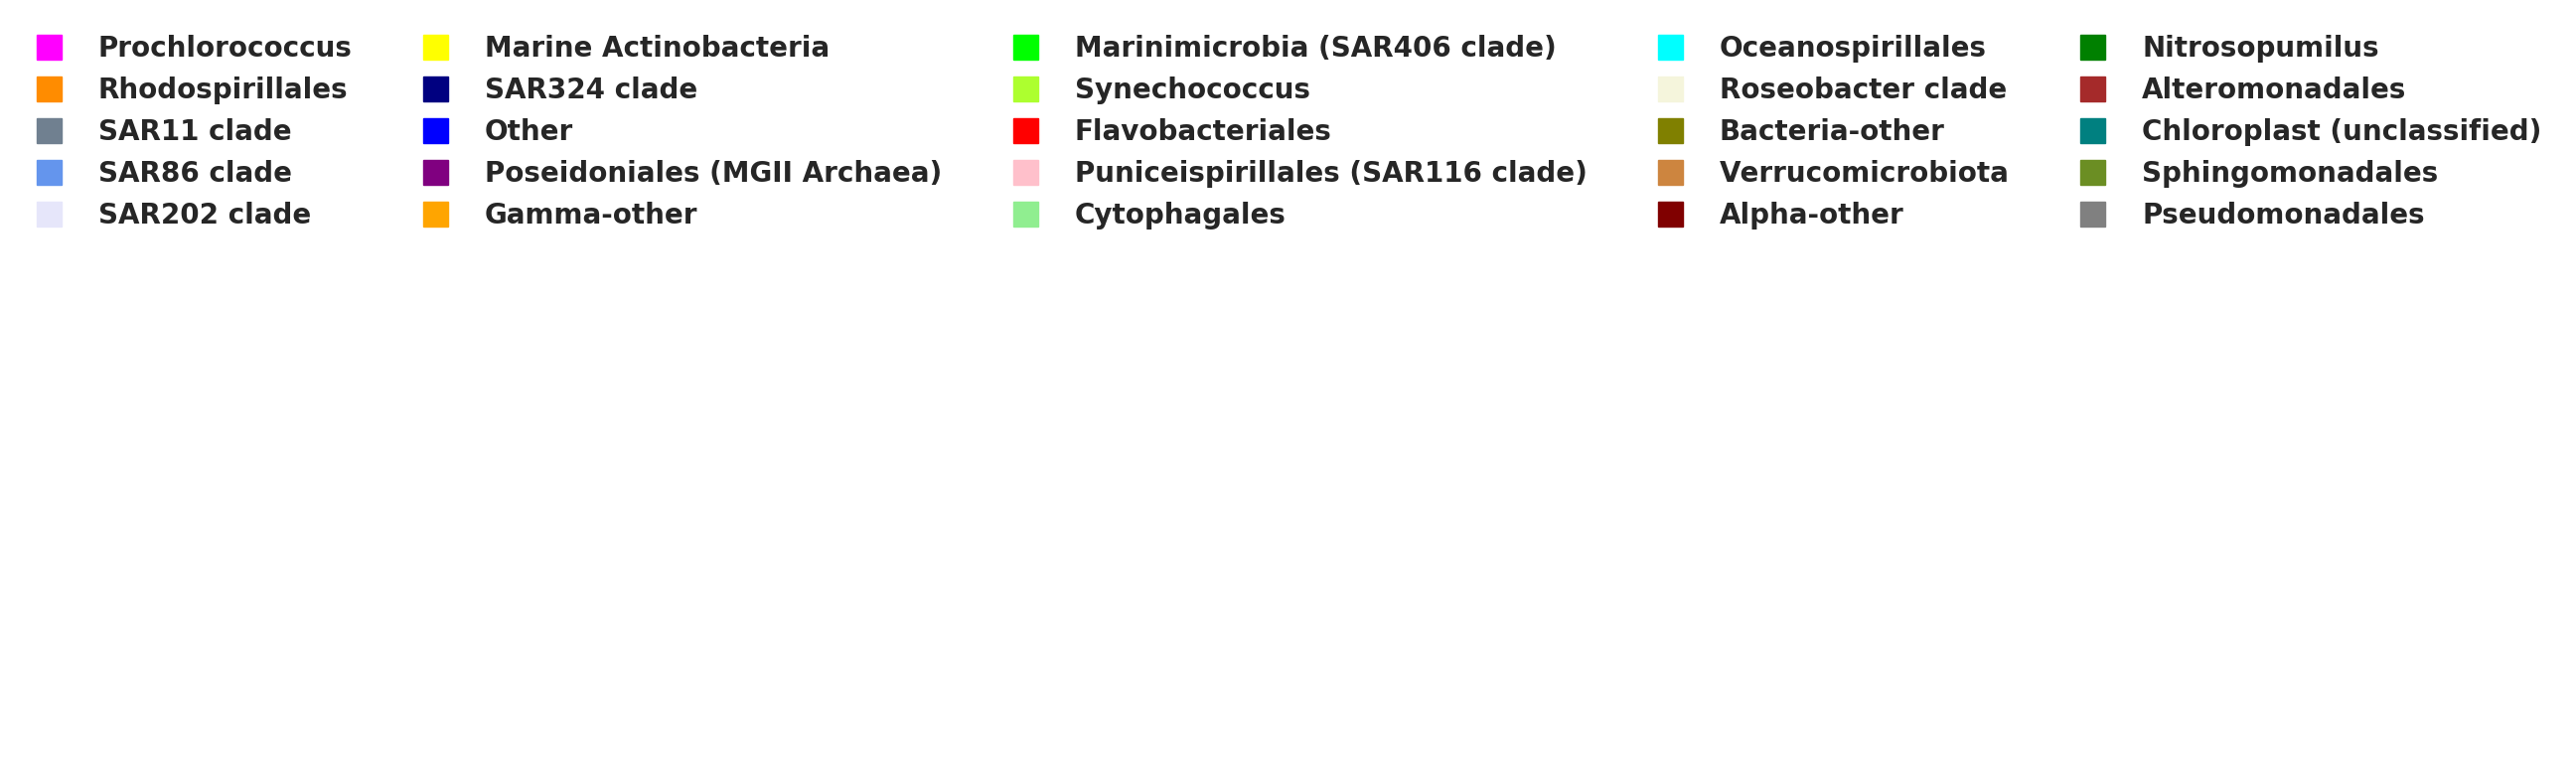

<Figure size 432x288 with 0 Axes>

In [21]:
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
fig, ax  = plt.subplots(dpi = 100, figsize = (30,10))
handles = [f("s", i) for i in list(species_col_dict_.values())]
plt.legend(handles, list(species_col_dict_.keys()), loc=1, framealpha=1, frameon=False, ncol=5, prop={'size': 20}, markerscale = 3)
plt.gca().set_axis_off()
plt.show()
plt.tight_layout()
fig.savefig(figfol + 'MI2Anotx.png')

In [22]:
val,count = np.unique(temp_df['ECR'],return_counts = True)
species_ecr_dict = dict(zip(val,count))

In [23]:
tem = pd.read_csv('species_tax_anot.amended.csv').iloc[:,[1,12]]
tem.index = tem['Label']
temp = df_plotP.transpose()
temp['ECR'] = temp.index
temp = temp.reset_index()#.groupby('ECR').agg('sum')
for i in range(temp.shape[0]):
    if temp['index'][i].find('Other') == 0:
        temp['index'][i] = temp['index'][i].replace('Other', tem.loc[temp['index'][i].split(' [')[1][:-1]][1])

temp.index = temp['index']
temp = temp.drop(['index','ECR','Other'], axis = 1) 
# temp = temp.drop(['Other'], axis = 0) 
# temp
for i in temp.columns:
    temp[i] = np.round(temp[i]/species_ecr_dict[i],1)
temp.index = [temp.index[i] + '['+str(i)+']' for i in range(temp.shape[0])]
temp = temp.iloc[temp.index.argsort(),:]

temp2 = df_plotN.transpose()
temp2['ECR'] = temp2.index
temp2 = temp2.reset_index()#.groupby('ECR').agg('sum')
temp2.index = temp2['index']
for i in range(temp2.shape[0]):
    if temp2['index'][i].find('Other') == 0:
        temp2['index'][i] = temp2['index'][i].replace('Other', tem.loc[temp2['index'][i].split(' [')[1][:-1]][1])

temp2 = temp2.drop(['index','ECR','Other'], axis = 1) 
# temp2 = temp2.drop(['Other'], axis = 0) 
# temp2
for i in temp2.columns:
    temp2[i] = np.round(temp2[i]/species_ecr_dict[i],1)
temp2.index = [temp2.index[i] + '['+str(i)+']' for i in range(temp2.shape[0])]
temp2 = temp2.iloc[temp2.index.argsort(),:]

/mnt/home/amishra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/mnt/home/amishra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### <font color=blue>Joint summary of the positive and negative interactions</font>

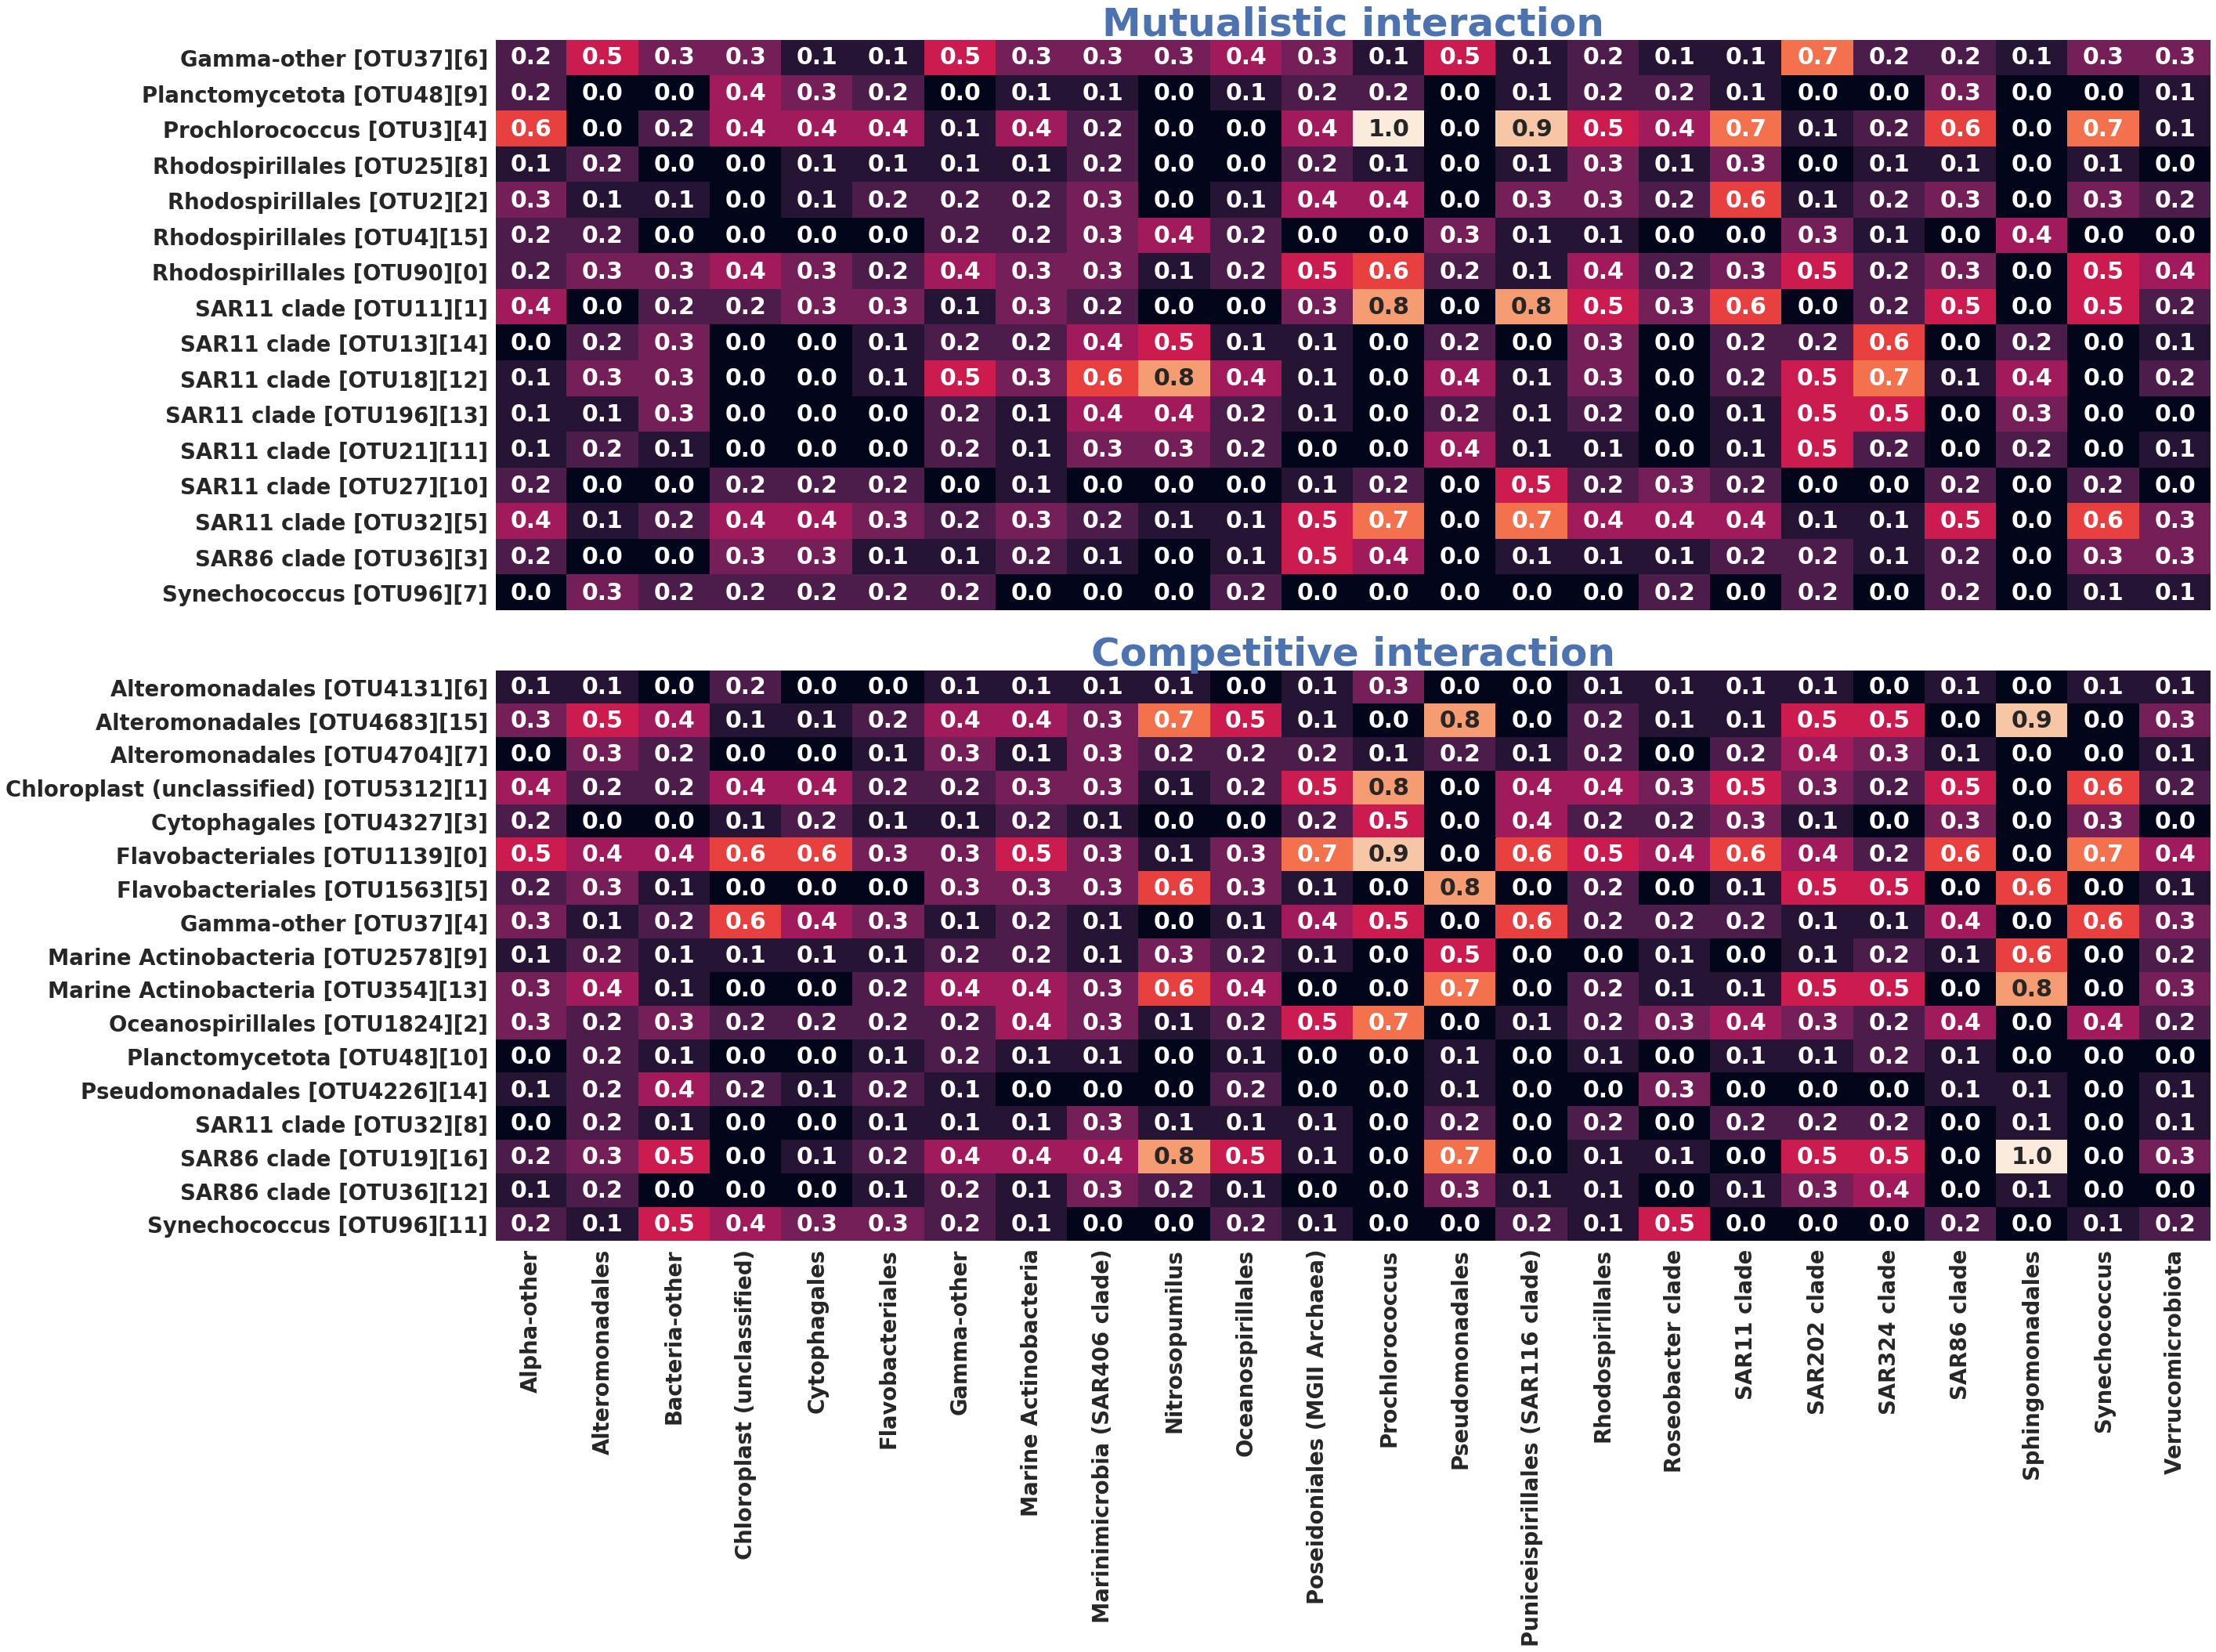

In [24]:
sns.set(font_scale=2.5)
fig, ax = plt.subplots(nrows=2, ncols =1, figsize = (40,30), sharex = True)
#cbar_ax = fig.add_axes([0, 100, 300, 500])
sns.heatmap(temp, annot=True, ax = ax[0], fmt='',\
            annot_kws={"fontsize": 30}, cbar = None, vmin = 0, vmax = 1, cbar_kws = {'orientation':'horizontal'})
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].set_title('Mutualistic interaction', c = 'b', fontsize=50)
sns.heatmap(temp2, annot=True, ax = ax[1], fmt='',\
            annot_kws={"fontsize": 30},cbar = None, vmin = 0, vmax = 1)
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].set_title('Competitive interaction', c = 'b', fontsize=50)
fig.tight_layout()
fig.savefig(figfol + 'MI2FinalS.png')

### Significant Association Matrix
Here we present code to summarize the findings of important association matrix. 

In [26]:
def get_descript(tem_s):
    a,b = tem_s.split(' [')
    b,c = b[:-1].split('][')
    return (a,b,c)

pos_sm = {}
for i in range(temp.shape[0]):
    j = temp.iloc[i,:] >= 0.5
    ord_x = temp.iloc[i,:][j].argsort()
    if sum(j) > 0:
        a,b,c = get_descript(temp.index[i])
        pos_sm[i] = [c, b, a, round(g_sub.nodes[b]['Abundance']/139,1), ', '.join(np.array(temp.columns)[j][ord_x])] 
pos_sm  = pd.DataFrame(pos_sm).transpose().reset_index().iloc[:,1:]
pos_sm = pos_sm.iloc[(-1*pos_sm.iloc[:,3]).argsort(),:]
pos_sm = pos_sm.reset_index()
# {i:[temp.index[i], ', '.join(np.array(temp.columns)[temp.iloc[i,:] >= 0.5])] for i in range(temp.shape[0])} 
neg_sm = {}
for i in range(temp2.shape[0]):
    j = temp2.iloc[i,:] >= 0.5
    ord_x = temp2.iloc[i,:][j].argsort()
    if sum(j) > 0:
        a,b,c = get_descript(temp2.index[i])
        neg_sm[i] = [c, b, a, round(g_sub.nodes[b]['Abundance']/139,1) , ', '.join(np.array(temp2.columns)[j][ord_x])] 
neg_sm  = pd.DataFrame(neg_sm).transpose().reset_index().iloc[:,1:]
neg_sm = neg_sm.iloc[(-1*neg_sm.iloc[:,3]).argsort(),:]
neg_sm = neg_sm.reset_index()

In [27]:
pd.concat([pos_sm.drop('index',axis=1), neg_sm.drop('index',axis=1)], axis=1).to_csv('interaction_sumary.csv', index = False)